# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [50]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from lightgbm.sklearn import LGBMRegressor



import warnings
warnings.filterwarnings('ignore')

In [66]:
#import data to data frame

df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv')

In [67]:
#explore data frame

df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [68]:

df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [70]:
#check for duplicates
df.duplicated().sum()

0

In [71]:
#apply dattime format to datetime column
df['datetime'] = df['datetime'].apply(pd.to_datetime)

In [72]:
#look at the max date
df.datetime.max()

Timestamp('2018-08-31 23:50:00')

In [73]:
#look at min date
df.datetime.min()

Timestamp('2018-03-01 00:00:00')

In [74]:
#reset the index to datetime column
df.set_index('datetime', inplace=True)

In [75]:
#sort index by time
df.sort_index(inplace=True)

In [76]:
#check to see if datetime is monotonic increasing
print(df.index.is_monotonic_increasing)

True


In [77]:
#resample data to 1 hour time frame
df = df.resample('1H').sum()

In [78]:
#view data 
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

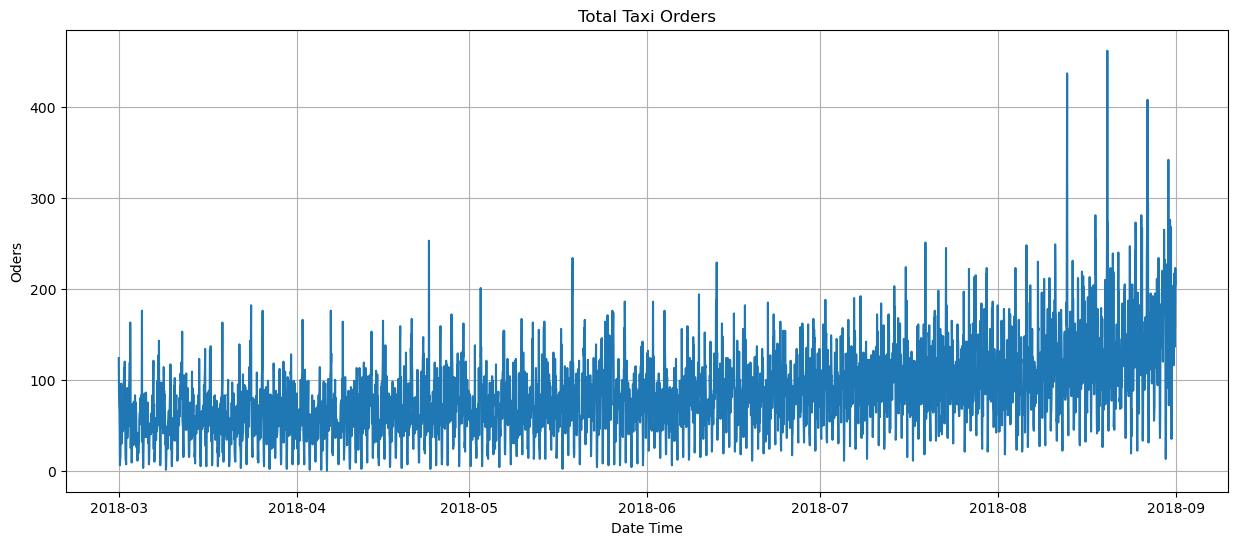

In [88]:
ts = df.groupby(['datetime'])['num_orders'].sum()
plt.figure(figsize=(15,6))
plt.title('Total Taxi Orders')
plt.xlabel('Date Time')
plt.ylabel('Oders')
plt.grid(True)
plt.plot(ts)

We see that the number of orders for taxi has been on the rise as the year has gone on. We see this in the upward trend of the data. 

In [89]:
#create decompsed to analyze data
decomposed = seasonal_decompose(df)

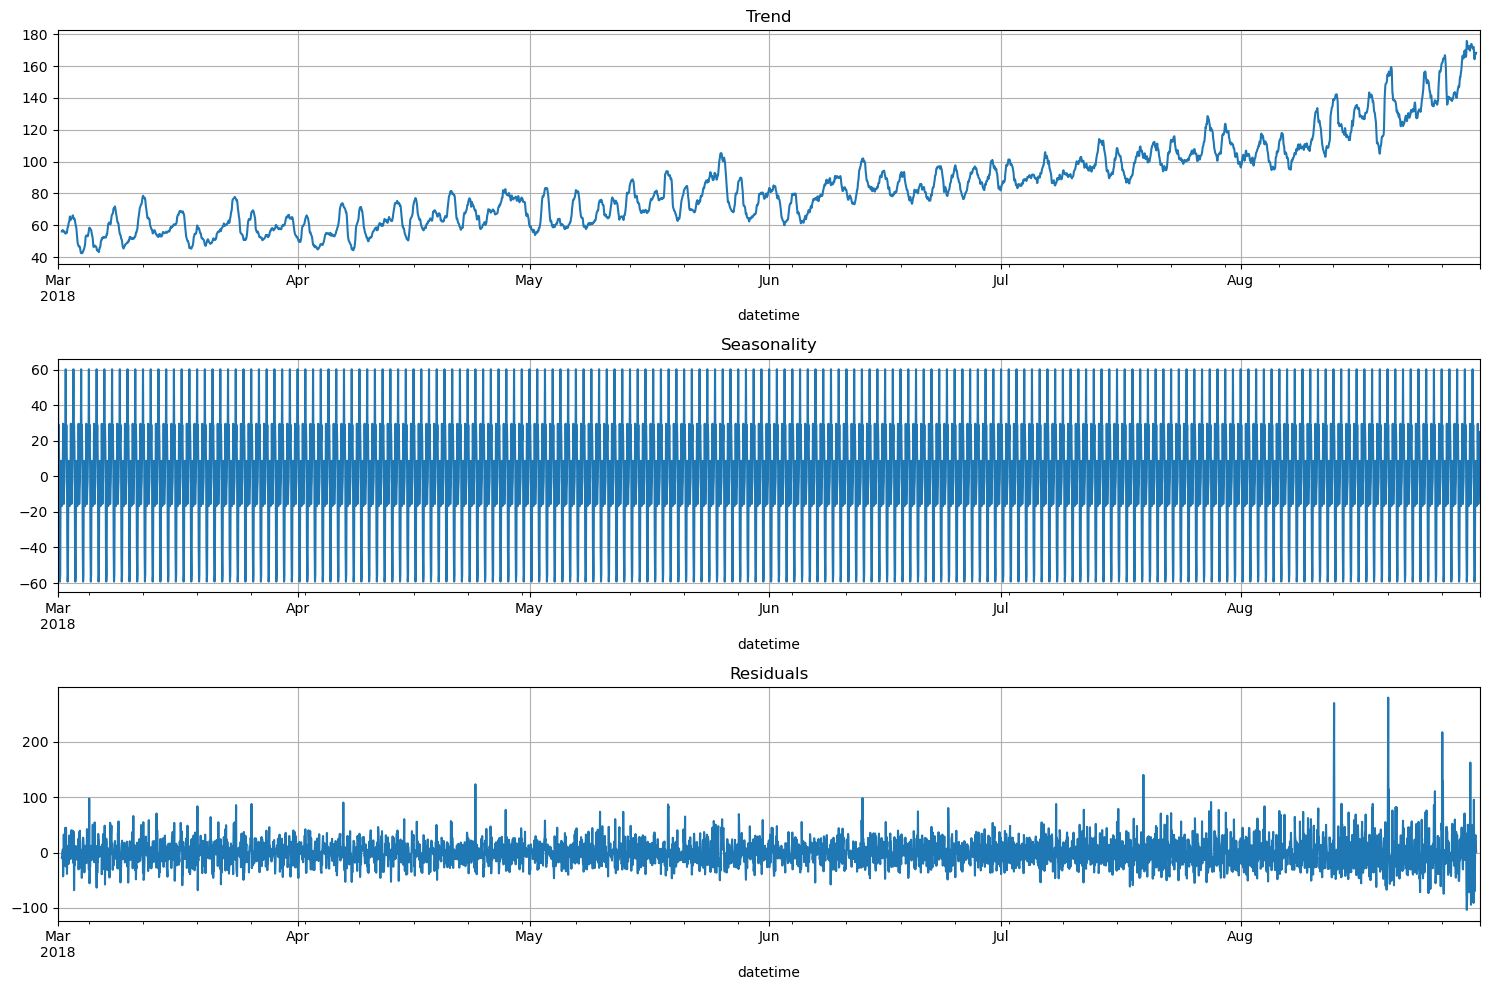

In [96]:
#trend
plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15,10))
plt.title('Trend')
plt.grid(True)

#Seasonal
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15,10))
plt.title('Seasonality')
plt.grid(True)

#Residuals
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), figsize=(15,10))
plt.title('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

1. <b>Trend</b> Our tend line clearly shows an increase overtime of the number of taxis ordered. Confirming our initial observations

2. <b>Seasonal</b> Our seasonal chart is to tight in time, we will futher explore below on two different 24 hour periods 

3. <b>Residuals</b> The residuals show the noise and irregularities not captured by the trend and seasonal.In this data set we see an incease in the noise at the end of our set. This could be due to the increase in the structure size adding to the noise. As we can see in the our original chart.  

Take a look at the first 24 hours and then the 24 for seasonality. To make to see the pattern

Text(0.5, 1.0, 'Seasonality Mar 2nd')

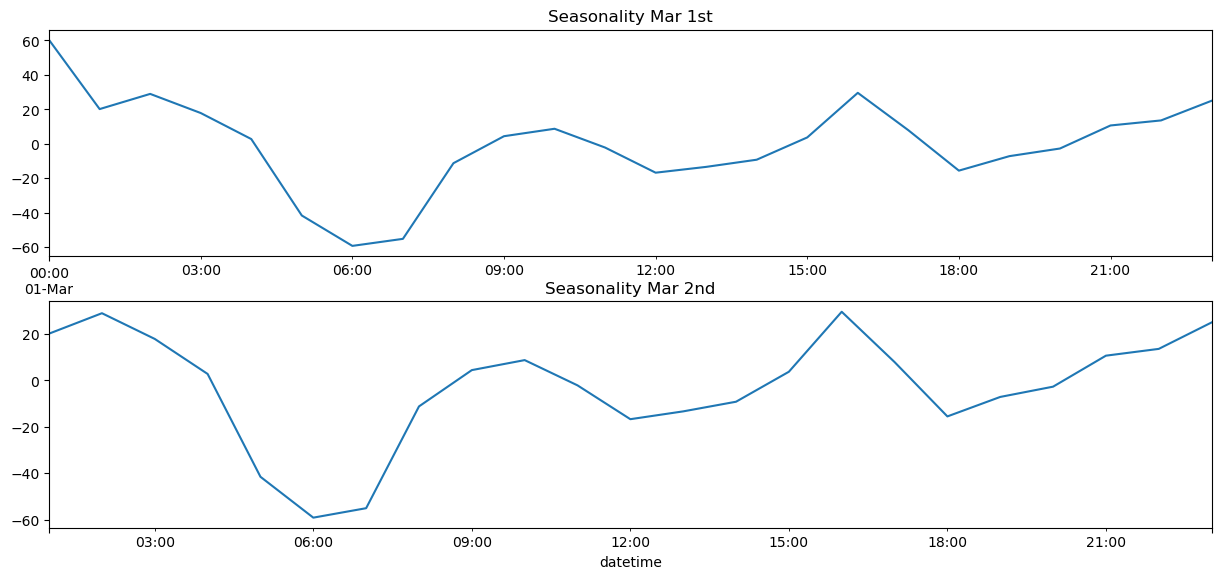

In [138]:
plt.subplot(311)
decomposed.seasonal[0:24].plot(ax=plt.gca(), figsize=(15,10))
plt.title('Seasonality Mar 1st')

plt.subplot(312)
decomposed.seasonal[25:48].plot(ax=plt.gca(), figsize=(15,10))
plt.title('Seasonality Mar 2nd')

Looking at the seasonal data close for the period of two seperate days we can see similar patterens in when taxi orders are at the highest and lowest. Showing us that there is a daily trend 

In [27]:
def plotMovingAverages(series, window, plot_intervals= False, scale = 1.96, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5,))
    plt.title("Moving Average\n window size = {}".format(window))
    plt.plot(rolling_mean,'g', label='Rolling mean trend')

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae +scale * deviation)
        upper_bond = rolling_mean + (mae +scale * deviation)
        plt.plot(upper_bond, "r--", label = "Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        if plot_anomalies :
            anomalies = pd.DataFrame(index = series.index, columns=series.columns)
            anomalies[series < lower_bond] = sereis [series < lower_bond]
            anomalies[series > upper_bond] = sereis [series > upper_bond]
            plt.plor(anomalies, "ro", markersize = 10)

    plt.plot(series[window:], label="Actual values", alpha=0.5)
    plt.legend(loc="upper left")
    plt.grid(True)



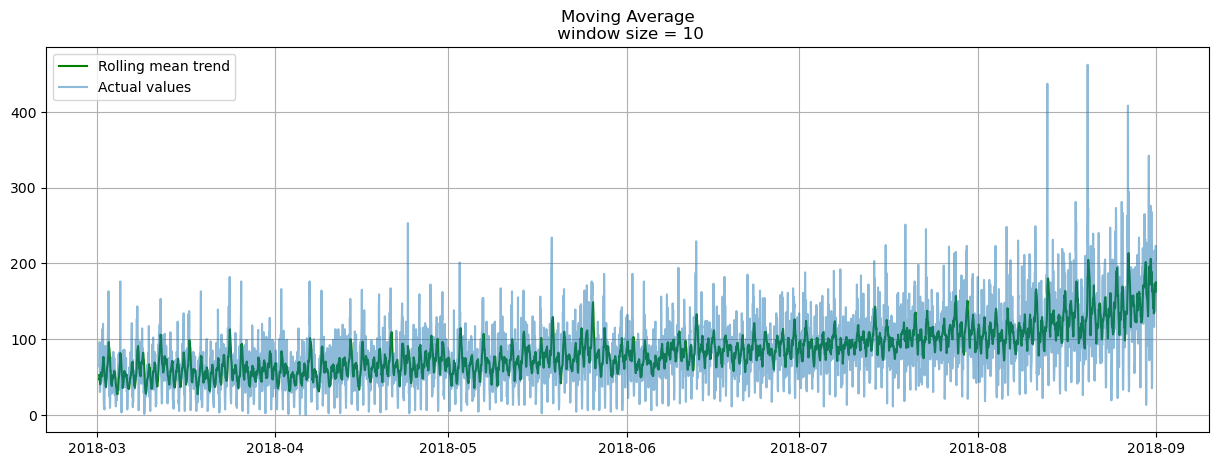

In [28]:
plotMovingAverages(df,10)

We can see that our rolling mean follows our trend data in this data view. 

## Training

In [102]:
ts = df.copy()

In [103]:
#shifts data to create our lag features
ts.shift(3)

,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,NaN
2018-03-01 02:00:00,NaN
2018-03-01 03:00:00,124.0
2018-03-01 04:00:00,85.0
...,...
2018-08-31 19:00:00,197.0
2018-08-31 20:00:00,217.0
2018-08-31 21:00:00,207.0


In [109]:
#create our features and lag features
ts['month'] = ts.index.month
ts['day'] = ts.index.day
ts['hour'] = ts.index.hour

for lag in range(1,25):
    ts['lag_{}'.format(lag)] = ts['num_orders'].shift(lag)

ts['roling_mean'] = ts['num_orders'].shift().rolling(24).mean()


In [111]:
#drop our rows with Nan values
ts = ts.dropna()


In [35]:

#create our traaining, valid, and test data
train_valid, test  = train_test_split(ts, shuffle=False,test_size =0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size = 0.1)


In [36]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [37]:
#check our ratios of the data
print('Ratio:', target_train.shape[0]/len(df),target_valid.shape[0]/len(df),target_test.shape[0]/len(df))

Ratio: 0.8052536231884058 0.08967391304347826 0.09963768115942029


In [38]:
def rmse(true, pred):
    return mean_squared_error(true, pred) **0.5

Linear Regression Model

In [112]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

lr_predict_train = lr_model.predict(features_train)
lr_predict_valid = lr_model.predict(features_valid)


print("RMSE Train:", mean_squared_error(target_train, lr_predict_train)**0.5)
print("RMSE Valid:", mean_squared_error(target_valid, lr_predict_valid)**0.5)


RMSE Train: 24.603321739910548
RMSE Valid: 34.2305610544928


Random Forest Regression

In [40]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=12345)
rf_model.fit(features_train, target_train)

rf_predict_train = rf_model.predict(features_train)
rf_predict_valid = rf_model.predict(features_valid)


print(f"RMSE Train:", mean_squared_error(target_train, rf_predict_train)**0.5)
print(f"RMSE Valid:", mean_squared_error(target_valid, rf_predict_valid)**0.5)



RMSE Train: 8.01657333124653
RMSE Valid: 32.41105738257494


LGBM Regression Model

In [41]:
lgbm_model = LGBMRegressor(learning_rate=0.2, max_depth=5, n_estimators=100, num_leaves=2, random_state=12345)
lgbm_model.fit(features_train, target_train)

lgbm_predict_train = lgbm_model.predict(features_train)
lgbm_predict_valid = lgbm_model.predict(features_valid)


print("RMSE Train:", mean_squared_error(target_train, lgbm_predict_train)**0.5 )
print("RMSE Valid:", mean_squared_error(target_valid, lgbm_predict_valid)**0.5 )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4556
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 28
[LightGBM] [Info] Start training from score 74.948538
RMSE Train: 22.82748779545218
RMSE Valid: 36.48617880662578


Gadient Boosting Regressor

In [114]:
gbr_model =  GradientBoostingRegressor(n_estimators=100, random_state=12345)
gbr_model.fit(features_train, target_train)

gbr_predict_train = gbr_model.predict(features_train)
gbr_predict_valid = gbr_model.predict(features_valid)


print("RMSE Train:", mean_squared_error(target_train, gbr_predict_train)**0.5 )
print("RMSE Valid:", mean_squared_error(target_valid, gbr_predict_valid)**0.5 )

RMSE Train: 18.784829303909437
RMSE Valid: 32.76001922657791


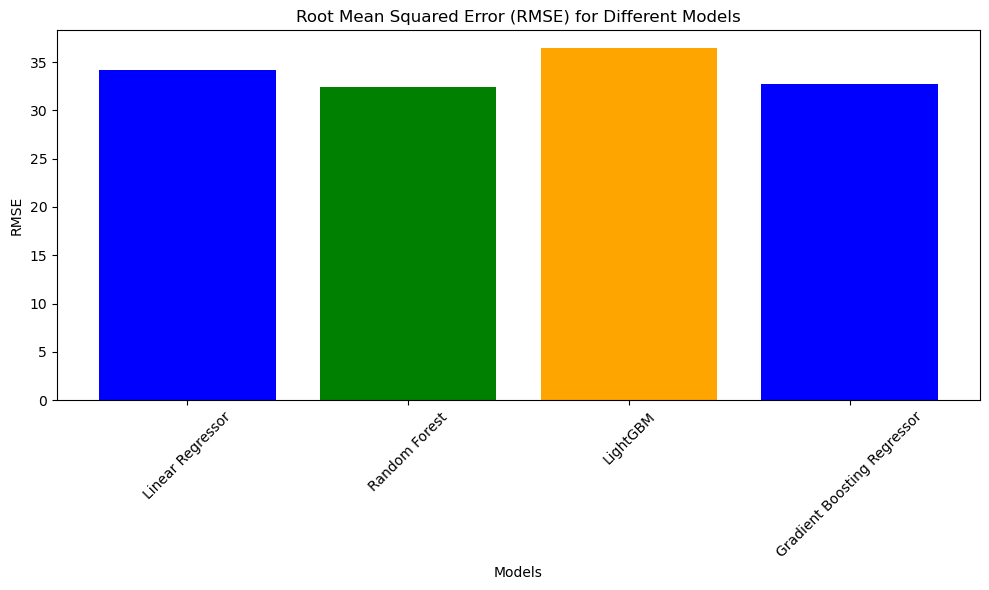

In [115]:
models = ['Linear Regressor', 'Random Forest', 'LightGBM', 'Gradient Boosting Regressor']
rmse_values = [34.23, 32.41, 36.48, 32.76]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) for Different Models')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

After Analyzing our models performance all our models performed well and meet our threshold of an RMSE being less than 48. Two of models did better, Random Forest and Gradient Boosting Regressors out preform our other two models. Moving forward we will use the Random Forest for our final model as it gave us our best RMSE score of 32.41

Random Forest Regressor Analyzation

Text(0.5, 1.0, 'Absolute Residuals Histogram')

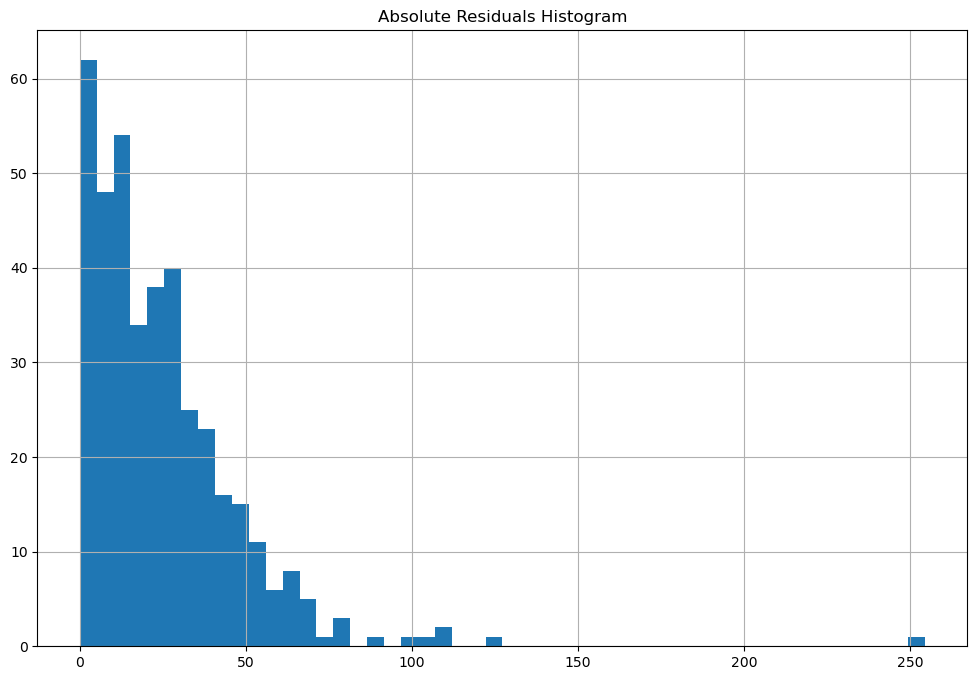

In [137]:
np.abs(target_valid - lr_predict_valid).hist(bins=50, figsize=(12,8))
plt.title('Absolute Residuals Histogram')


We see our distribution of errors being close to zero, except for one big error. 

<Figure size 1500x800 with 0 Axes>

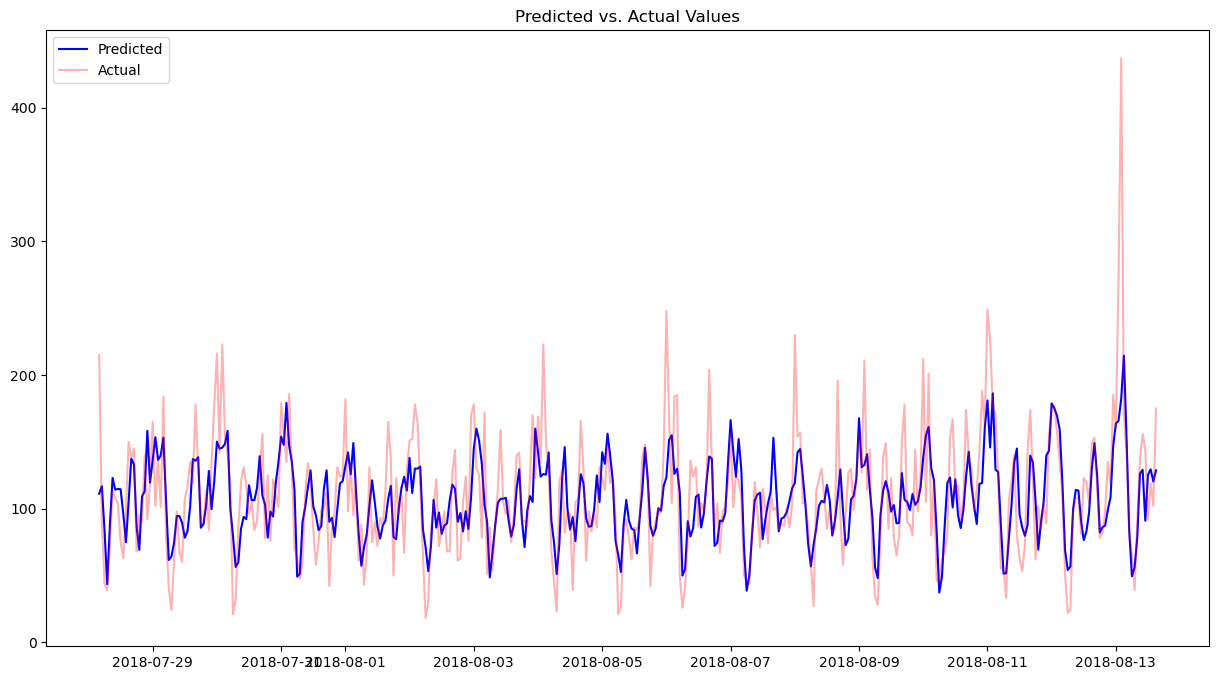

In [120]:
plt.figure(figsize=(15, 8))
plt.plot(features_valid.index, lr_predict_valid, label='Predicted', color='blue')
plt.plot(features_valid.index, target_valid, label='Actual', color='red', alpha=0.3)
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()

In this graph we are seeing our model prediction data over our acutal data. We can see that our model gives a relatively similar prediction to our data. We can also see the outlier error where our actual data had a big change which our model was unable to predict.

## Final Testing on our Random Forest Model

In [133]:
#create training set from our original train and validation sets combined.
features_train_f = train_valid.drop(['num_orders'], axis=1)
target_train_f = train_valid['num_orders']


In [136]:
#create a new randomforest regressor and run our final predictions and get RMSE score
rf_model = RandomForestRegressor(n_estimators=100, random_state=12345)
rf_model.fit(features_train_f, target_train_f)


rf_predict_test = rf_model.predict(features_test)


print("RMSE TEST:", mean_squared_error(target_test, rf_predict_test)**0.5 )



RMSE TEST: 43.99568321799517


## Conclusion
- All of our models performed well and meet our threshold of lower than an RMSE scoreof  48
- However two performed better than the other two. These where the Random Forest and Gradient Boosting Regression Models. 
- In the end we choose the Random Forest Regressor to move forward as it performed the best with a RMSE score of 32.41 on our initial data sets. When we further analysed the perdictions against our target data we saw the model was performing well. 
- As we performed our predictions on our testing datasets we saw a RMSE score of a 43.99 which meets our threshold of lower than a 48

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48